# RVAA - RealVsAiArt-based model
This notebook contains the code of our attempts at training a model on the RVAA dataset. 

The RVAA dataset contains around 2k images, which can either be real or AI-generated. However, unlike CIFAKE, the images are completely heterogenous: they have different resolution, different aspect-ratios and even different RGB formats. In addition, some of the images tagged as AI-generated are only "partially" so: in some cases, an image from a diffusion model will be shown side-by-side with a real image, or text will be present all over the image.

This can pose quite the challenge for our model. Nevertheless, the final results are quite promising.

In [1]:
import torch
from torchvision.models import resnet50
import model_utils
import plotter
import data_utils
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
import importlib
import pandas as pd
import torchvision.transforms as transforms

seed=42
model_utils.fix_random(seed)

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # fixes PIL warning

In [2]:
dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt")
df_stats = data_utils.get_dataset_stats(dataset)
pd.DataFrame.from_dict(df_stats, orient='index')

# size of image to resize
IMG_SIZE = 224

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),                  # Resize the shorter side to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square),  # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),      # Ensure the final image is exactly IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 32

train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.10), dataset=dataset)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

loss_fn = nn.BCEWithLogitsLoss()
device = model_utils.get_device()
print(f"using {device} device")

dataloaders = (train_dataloader, val_dataloader)

using cuda device


In [4]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
ft_resnet50.to(device)

optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50"

In [5]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 66.0%, Avg loss: 0.598128
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 58.8%, Avg loss: 0.555201
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 73.2%, Avg loss: 0.547056
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 67.0%, Avg loss: 0.520329
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 74.2%, Avg loss: 0.508991
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 63.9%, Avg loss: 0.499158
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------
Validatio

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 78.4%, Avg loss: 0.510045
Confusion matrix report, tp: 63, fp: 22, fn: 20, tn:89


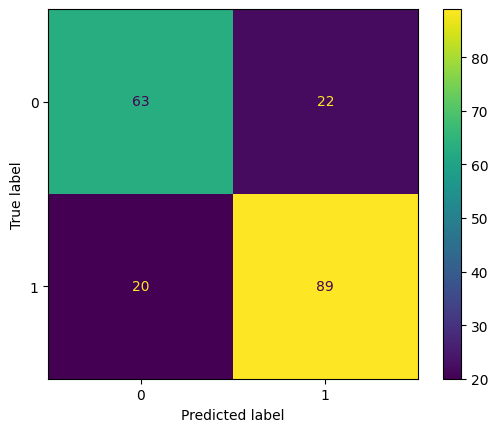

Precision: 0.74, Recall: 0.76, F1-Score: 0.75


(0.5100451282092503, tensor(0.7835, device='cuda:0'))

In [6]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name, visualize=True)

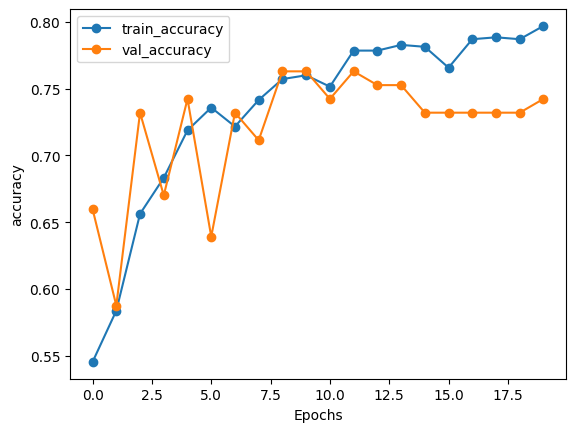

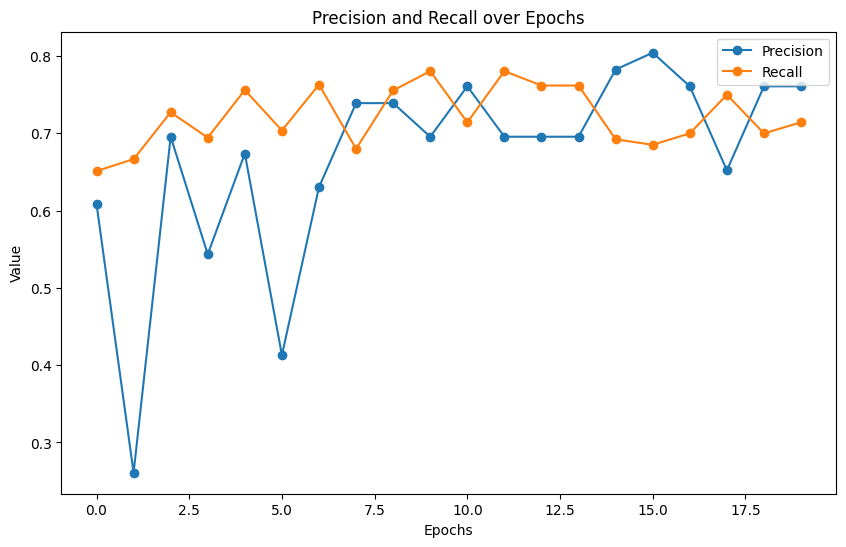

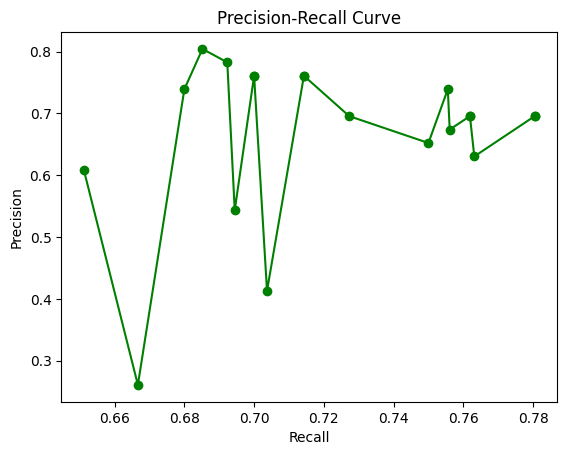

In [7]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

Step2 FT

In [8]:
for param in ft_resnet50.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_beefy"

In [9]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 63.9%, Avg loss: 2.104518
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 67.0%, Avg loss: 0.784250
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 74.2%, Avg loss: 1.249818


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 69.1%, Avg loss: 0.983927


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 59.8%, Avg loss: 1.492676


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 74.2%, Avg loss: 0.831047


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 66.0%, Avg loss: 0.959277


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 80.4%, Avg loss: 0.677556
New best model found! (based on lowest loss)
...and saved.


Epoch 9/20
--------------------

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 87.1%, Avg loss: 0.415786
Confusion matrix report, tp: 76, fp: 9, fn: 16, tn:93


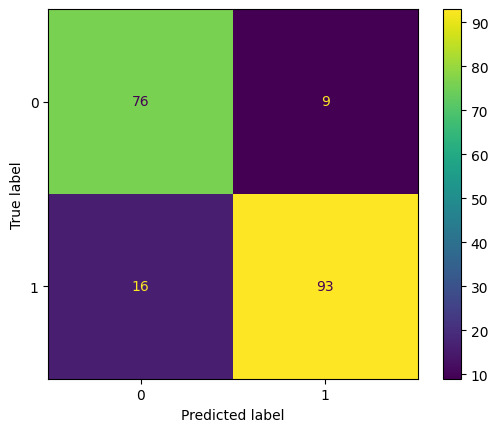

Precision: 0.89, Recall: 0.83, F1-Score: 0.86


(0.4157857860638095, tensor(0.8711, device='cuda:0'))

In [10]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name, visualize=True)

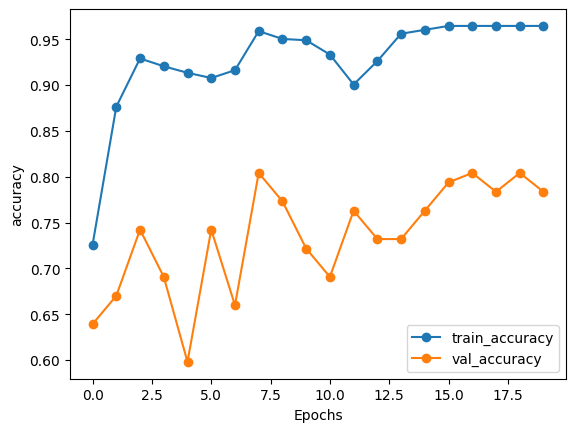

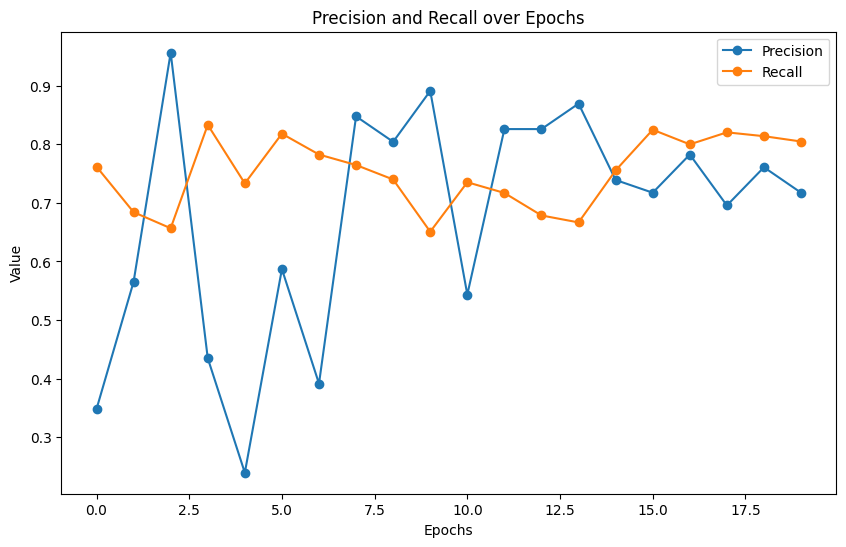

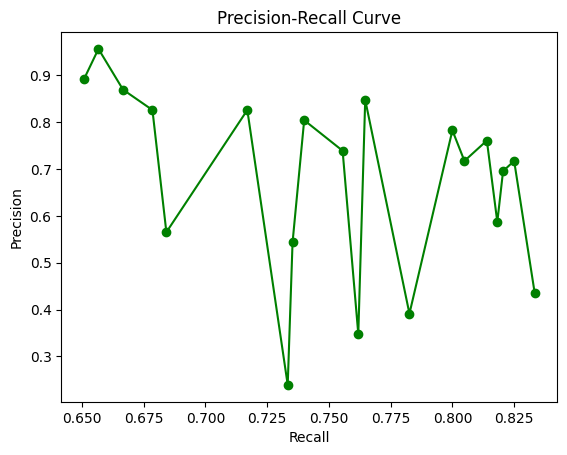

In [11]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

GradCAM Test

100%|██████████| 64/64 [00:10<00:00,  6.00it/s]


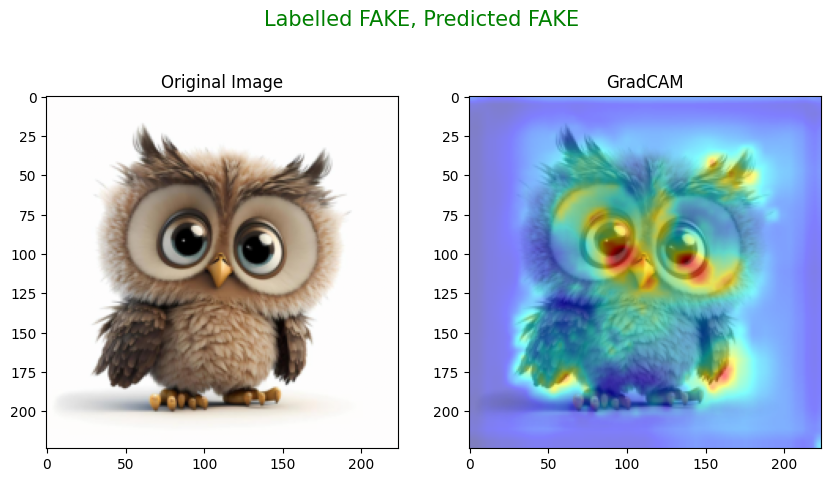

In [13]:
import xai

xai.set_device(device)
xai.explain_gradcam_single_image(train_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                index = 3)

100%|██████████| 64/64 [01:27<00:00,  1.37s/it]


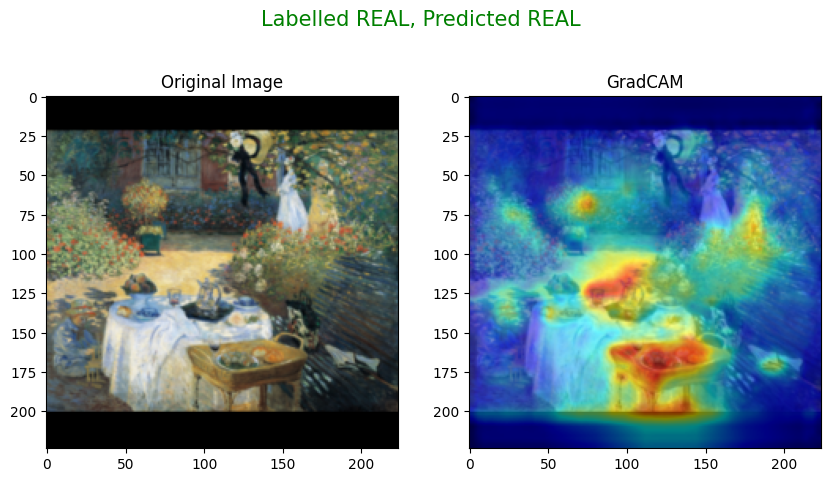

In [14]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                index = 2)

LIME experiment

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141494750977..2.640000104904175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141494750977..2.640000104904175].


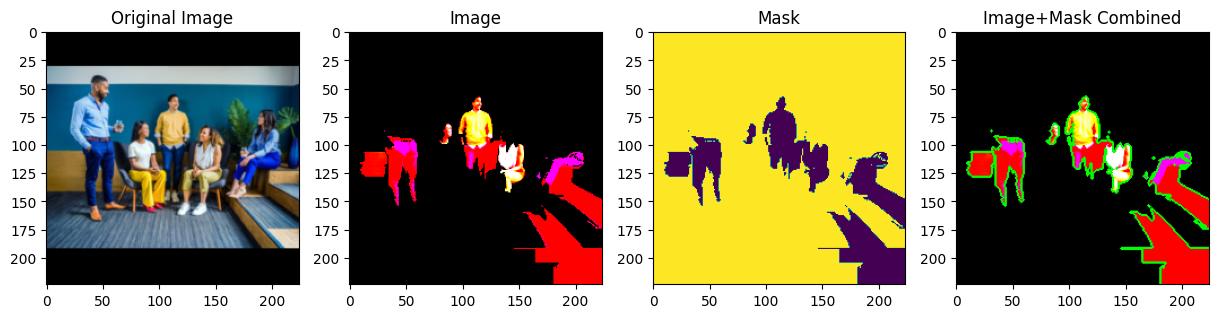

In [15]:
xai.explain_lime_single_image(train_dataloader, ft_resnet50)

### Data Augmentation Experiment
ignore if it not worky welly.

In [16]:
augmented_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.RandomResizedCrop(size=(224, 224)),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(20),  # Randomly rotate the image by up to 20 degrees
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [33]:
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np
from torchvision import transforms

original_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

# we are doing the same thing as the train_test_split function
train_size = int(0.7 * len(original_dataset))
val_size = int(0.15 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

# TODO: remove this and put it at top
generator = torch.Generator()
generator.manual_seed(seed)
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(original_dataset)),
    [train_size, val_size, test_size],
    generator=generator
)

train_dataset = Subset(original_dataset, train_indices)
val_dataset = Subset(original_dataset, val_indices)
test_dataset = Subset(original_dataset, test_indices)

augmented_size = int(1.0 * len(train_dataset))
augmented_indices = np.random.choice(len(train_dataset), augmented_size, replace=False)

augmented_train_dataset = Subset(data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=augmented_transform),
                                 [train_indices[i] for i in augmented_indices])

combined_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

train_dataloader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = (train_dataloader, val_dataloader)


In [34]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment"

In [35]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------
Training loss: 0.627484, train accuracy: 58.91%  [ 1280/ 1358]
Validation Error:
Accuracy: 71.0%, Avg loss: 0.615188
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.615184, train accuracy: 68.98%  [ 1280/ 1358]
Validation Error:
Accuracy: 75.9%, Avg loss: 0.579284
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.602927, train accuracy: 71.25%  [ 1280/ 1358]
Validation Error:
Accuracy: 74.5%, Avg loss: 0.560063
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.586632, train accuracy: 74.30%  [ 1280/ 1358]
Validation Error:
Accuracy: 76.6%, Avg loss: 0.545561
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Training loss: 0.500113, train accuracy: 75.62%  [ 1280/ 1358]
Validation

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 78.1%, Avg loss: 0.474946
Confusion matrix report, tp: 45, fp: 17, fn: 15, tn:69


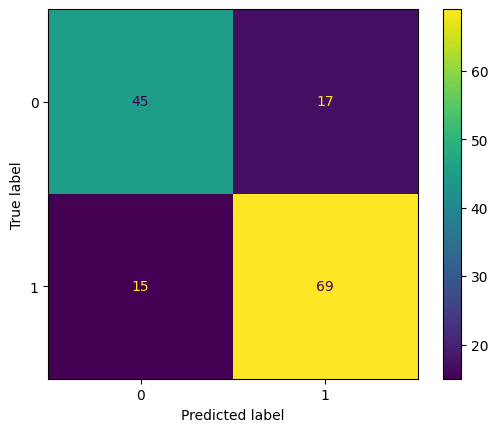

Precision: 0.73, Recall: 0.75, F1-Score: 0.74


(0.47494571208953856, tensor(0.7808, device='cuda:0'))

In [36]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name, visualize=True)

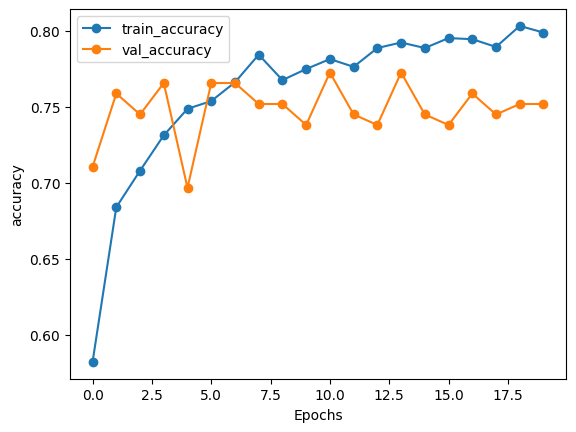

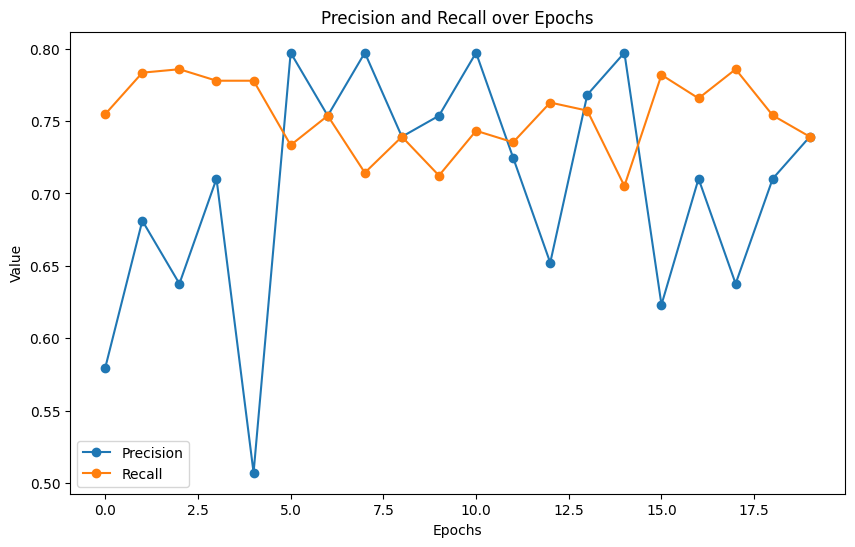

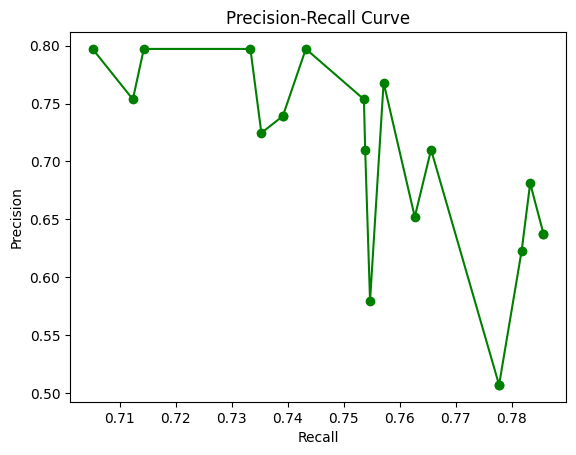

In [37]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

In [38]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment_beefy"

In [39]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------
Training loss: 0.494938, train accuracy: 74.38%  [ 1280/ 1358]
Validation Error:
Accuracy: 69.0%, Avg loss: 0.947051
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.327463, train accuracy: 85.47%  [ 1280/ 1358]
Validation Error:
Accuracy: 72.4%, Avg loss: 0.771834
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.195018, train accuracy: 90.08%  [ 1280/ 1358]
Validation Error:
Accuracy: 76.6%, Avg loss: 0.512917
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.138643, train accuracy: 90.47%  [ 1280/ 1358]
Validation Error:
Accuracy: 71.7%, Avg loss: 1.054933


Epoch 5/20
-------------------------------
Training loss: 0.203704, train accuracy: 89.69%  [ 1280/ 1358]
Validation Error:
Accuracy: 77.2%, Avg loss: 0.614365


Epoch 6/20
--

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 83.6%, Avg loss: 0.410342
Confusion matrix report, tp: 49, fp: 13, fn: 11, tn:73


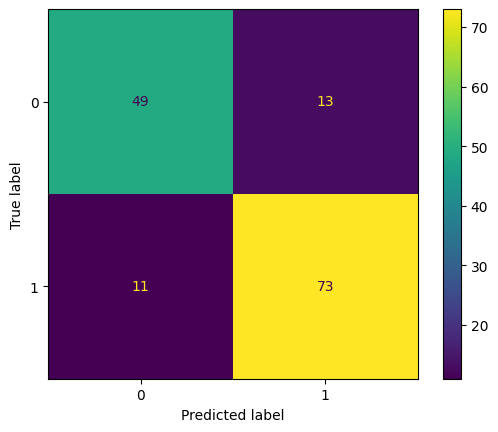

Precision: 0.79, Recall: 0.82, F1-Score: 0.80


(0.4103417158126831, tensor(0.8356, device='cuda:0'))

In [40]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name, visualize=True)

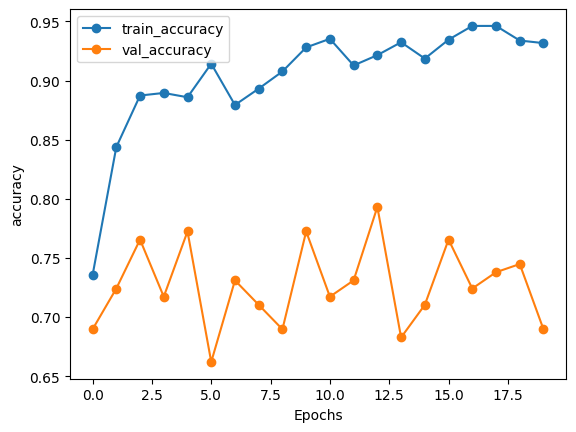

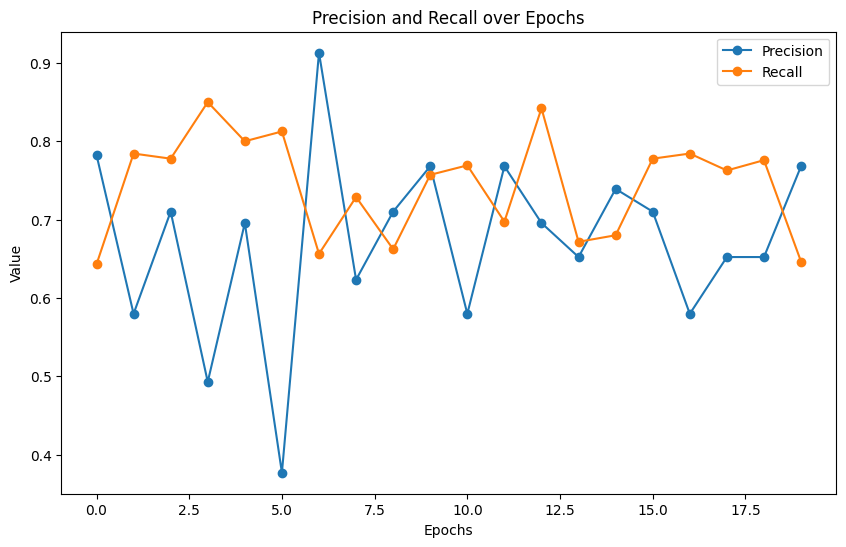

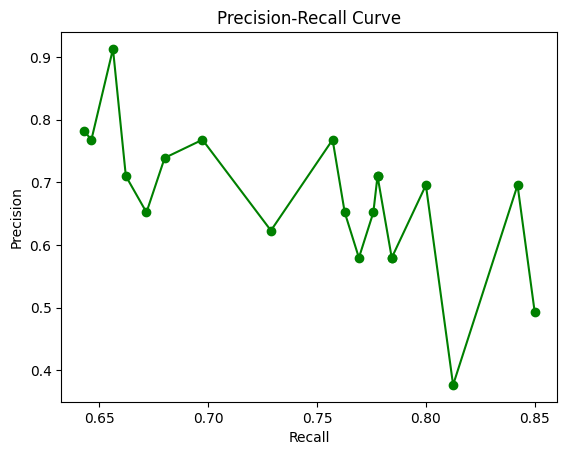

In [41]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)